In [1]:
%matplotlib inline

In [2]:
import sys
import os
import pandas as pd
import xarray as xr
from scipy.io import loadmat
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh

from tonic.io import read_configobj

from da_utils import (load_nc_and_concat_var_years, da_2D_to_3D_from_SMART,
                      setup_output_dirs, rmse)

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [153]:
# ============================================================ #
# Process command line arguments
# Read config file
# ============================================================ #
cfg = read_configobj(
    '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/ArkRed.EnKS.lambda_1.Q9.cfg')

In [154]:
# ============================================================ #
# Parameters
# ============================================================ #
start_date = pd.datetime.strptime(cfg['SMART_RUN']['start_date'], "%Y-%m-%d")
end_date = pd.datetime.strptime(cfg['SMART_RUN']['end_date'], "%Y-%m-%d")
start_year = start_date.year
end_year = end_date.year
window_size = cfg['SMART_RUN']['window_size']

In [155]:
# ============================================================ #
# Set up output directory
# ============================================================ #
output_dir = setup_output_dirs(
                    os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir']),
                    mkdirs=['plots'])['plots']

output_subdir_maps = setup_output_dirs(
                            output_dir,
                            mkdirs=['maps'])['maps']
output_subdir_ts = setup_output_dirs(
                            output_dir,
                            mkdirs=['time_series'])['time_series']

In [156]:
# ============================================================ #
# Load original and true prec data
# ============================================================ #
print('Loading data...')

# --- Load original prec (to be corrected) --- #
mat_smart_input = os.path.join(cfg['CONTROL']['root_dir'],
                               cfg['OUTPUT']['output_basedir'],
                               'prep_SMART', 'SMART_input.mat')
dict_smart_input = loadmat(mat_smart_input)

# --- Load original prec --- #
prec_orig = dict_smart_input['prec_orig']  # [cell, day]

# --- Load true prec --- #
prec_true = dict_smart_input['prec_true']  # [cell, day]

# Load in domain file
ds_domain = xr.open_dataset(os.path.join(cfg['CONTROL']['root_dir'],
                                         cfg['DOMAIN']['domain_file']))
da_mask = ds_domain['mask']

Loading data...


In [157]:
# --- Load SMART-corrected prec ensemble --- #
mat_prec_corr_ens = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'SMART_corrected_rainfall_ens.mat')
prec_corr_ens = loadmat(mat_prec_corr_ens)['RAIN_SMART_SMOS_ENS']  # [window, ens, grid_cell]

In [158]:
# --- Load SMART-corrected prec ensemble mean --- #
mat_prec_corr = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'SMART_corrected_rainfall.mat')
prec_corr = loadmat(mat_prec_corr)['RAIN_SMART_SMOS']  # [window, grid_cell]

In [159]:
# --- Load lambda --- #
mat_lambda = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'lambda.mat')
lambda_fraction = loadmat(mat_lambda)['lambda']

In [160]:
# --- Load innovation --- #
mat_innovation = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART', 'innovation.mat')
innovation = loadmat(mat_innovation)['innovation']

In [161]:
# ============================================================ #
# Aggregate original & true precip. to window size
# ============================================================ #
# Only keep complete windows
n_windows = len(prec_corr_ens)
prec_orig = prec_orig[:, :(n_windows*window_size)]
prec_true = prec_true[:, :(n_windows*window_size)]

In [162]:
# Aggregate windows
ncell = len(prec_orig)
prec_orig_window = prec_orig.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]
prec_true_window = prec_true.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]

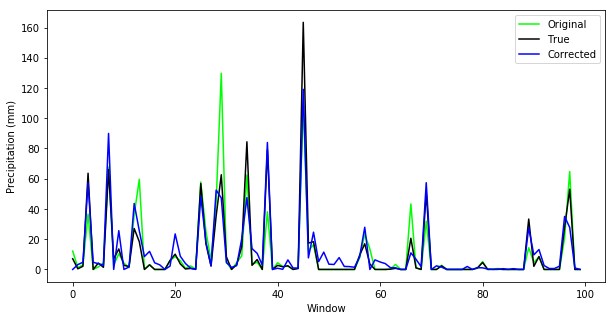

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(prec_orig_window[0, :100], color='lime', label='Original')
plt.plot(prec_true_window[0, :100], color='black', label='True')
plt.plot(prec_corr[:100, 0], color='blue', label='Corrected')
plt.xlabel('Window')
plt.ylabel('Precipitation (mm)')
plt.legend()

In [164]:
# ============================================================ #
# Calculate metrics (all based on window-aggregated precip.) (use post-processed corrected rainfall)
# ============================================================ #

In [165]:
days = pd.date_range(start_date, end_date, freq='D')

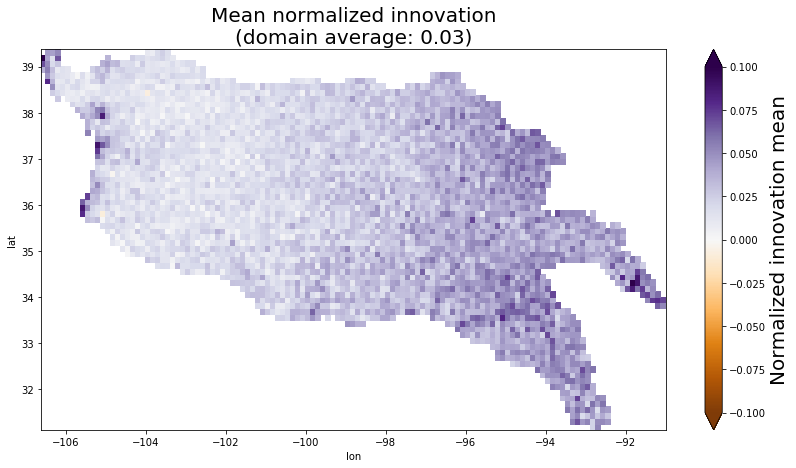

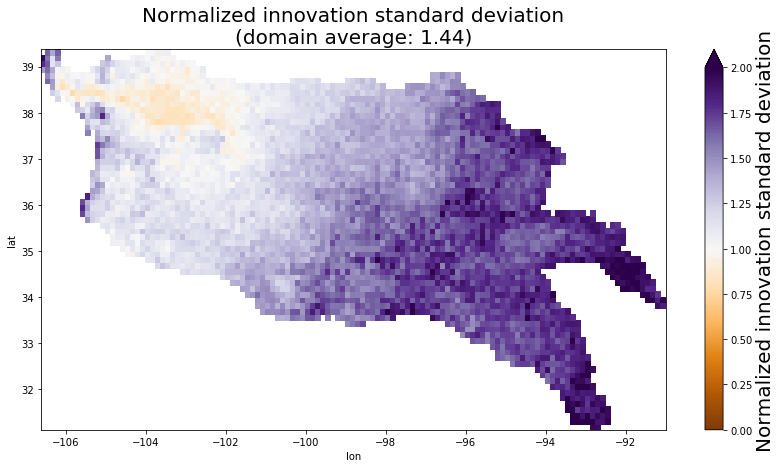

In [166]:
# --- Innovation --- #
innovation[innovation==-999] = np.nan
da_innov = da_2D_to_3D_from_SMART(
    dict_array_2D={'innov': innovation},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=days)['innov']
# Plot normalized innovation mean and standard deviation
# (1) Mean
da_innov_mean = da_innov.mean(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_mean.plot(
    add_colorbar=False, cmap='PuOr', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Normalized innovation mean', fontsize=20)
plt.title('Mean normalized innovation\n'
          '(domain average: {:.2f})'.format(float(da_innov_mean.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_norm_mean.png'),
            format='png', bbox_inches='tight')
# (2) Standard deviation
da_innov_std = da_innov.std(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_std.plot(add_colorbar=False, cmap='PuOr', vmin=0, vmax=2)
cbar = plt.colorbar(cs, extend='max').set_label('Normalized innovation standard deviation', fontsize=20)
plt.title('Normalized innovation standard deviation\n'
          '(domain average: {:.2f})'.format(float(da_innov_std.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_norm_std.png'),
            format='png', bbox_inches='tight')

In [167]:
# --- Lambda fraction --- #
da_lambda = da_2D_to_3D_from_SMART(
    dict_array_2D={'lambda': lambda_fraction},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['lambda'][0, :, :]

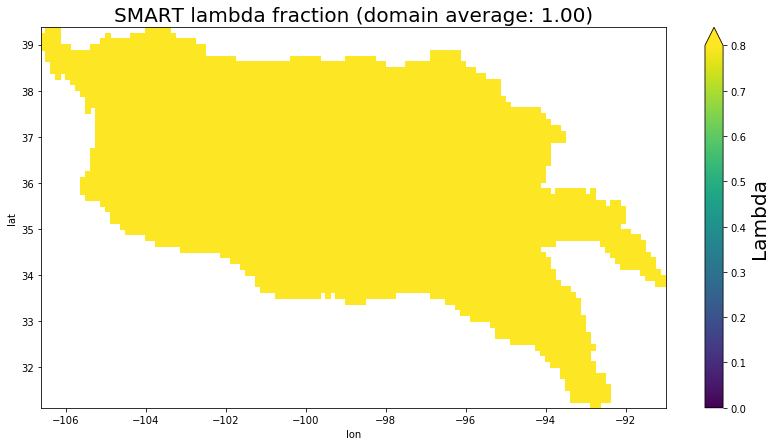

In [168]:
fig = plt.figure(figsize=(14, 7))
cs = da_lambda.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=0.8)
cbar = plt.colorbar(cs, extend='max').set_label('Lambda', fontsize=20)
plt.title('SMART lambda fraction '
          '(domain average: {:.2f})'.format(float(da_lambda.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'lambda_fraction.png'),
            format='png', bbox_inches='tight')

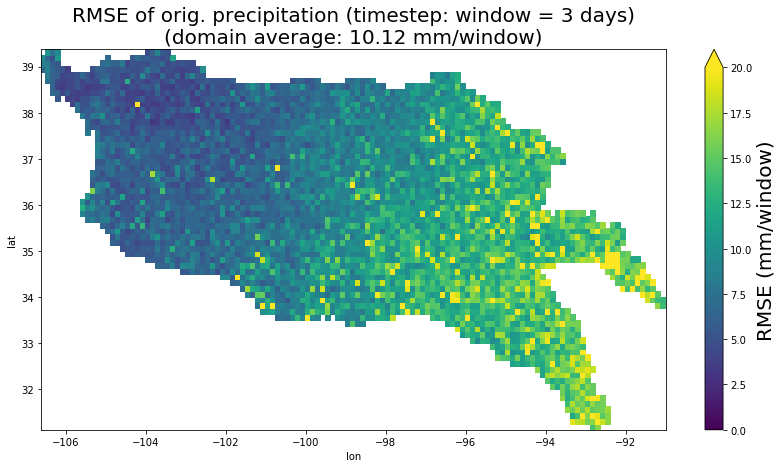

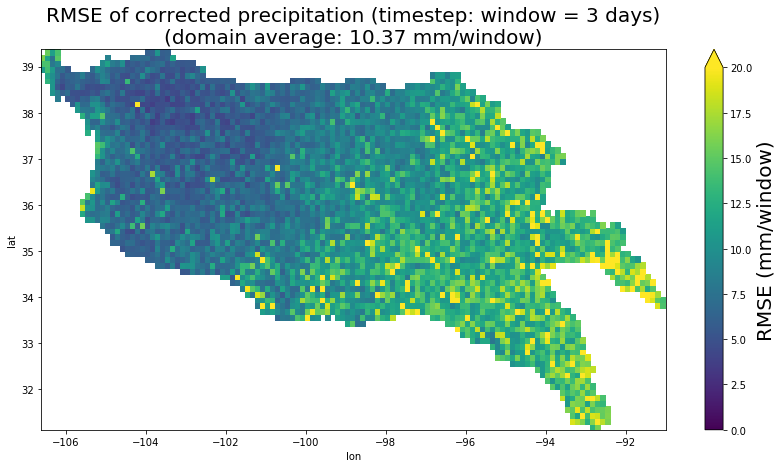

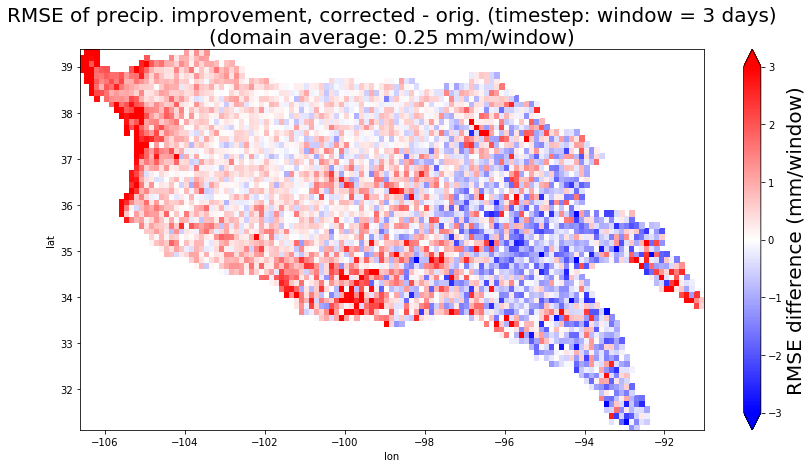

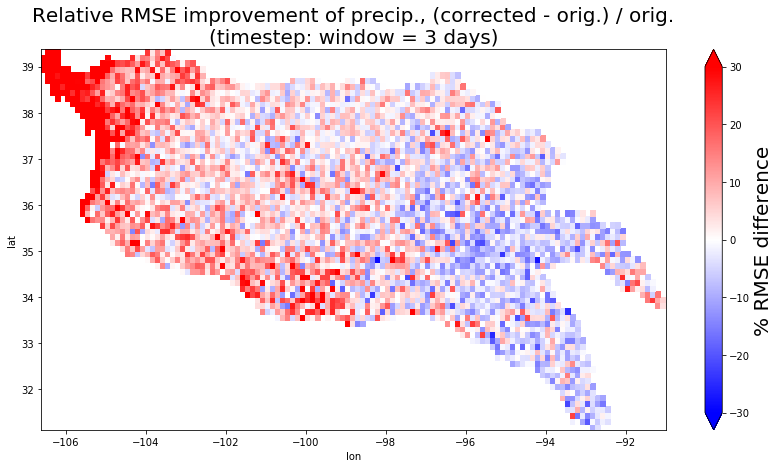

In [169]:
# --- Ensemble-mean RMSE --- #
# Calculate RMSE
rmse_orig = rmse(prec_orig_window.transpose(), prec_true_window.transpose())
rmse_corr = rmse(prec_corr, prec_true_window.transpose())
da_rmse_orig = da_2D_to_3D_from_SMART(
    dict_array_2D={'rmse': rmse_orig},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['rmse'][0, :, :]
da_rmse_corr = da_2D_to_3D_from_SMART(
    dict_array_2D={'rmse': rmse_corr},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['rmse'][0, :, :]
# RMSE of original precip.
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=20)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/window)', fontsize=20)
plt.title('RMSE of orig. precipitation (timestep: window = {} days)\n'
          '(domain average: {:.2f} mm/window)'.format(
              window_size,
              float(da_rmse_orig.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse_prec_orig.png'),
            format='png', bbox_inches='tight')
# RMSE of corrected precip.
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corr.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=20)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/window)', fontsize=20)
plt.title('RMSE of corrected precipitation (timestep: window = {} days)\n'
          '(domain average: {:.2f} mm/window)'.format(
              window_size,
              float(da_rmse_corr.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse_prec_corrected.png'),
            format='png', bbox_inches='tight')
# Improvement of RMSE (corrected - orig.)
da_rmse_diff = da_rmse_corr - da_rmse_orig
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_diff.plot(add_colorbar=False, cmap='bwr', vmin=-3, vmax=3)
cbar = plt.colorbar(cs, extend='both').set_label('RMSE difference (mm/window)', fontsize=20)
plt.title('RMSE of precip. improvement, corrected - orig. (timestep: window = {} days)\n'
          '(domain average: {:.2f} mm/window)'.format(
              window_size,
              float(da_rmse_diff.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse_prec_diff.png'),
            format='png', bbox_inches='tight')
# Relative improvement of RMSE, (corrected - orig.) / orig.
da_rmse_diff_relative = (da_rmse_corr - da_rmse_orig) / da_rmse_orig * 100
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_diff_relative.plot(add_colorbar=False, cmap='bwr', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('% RMSE difference', fontsize=20)
plt.title('Relative RMSE improvement of precip., (corrected - orig.) / orig.\n'
          '(timestep: window = {} days)'.format(window_size), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse_prec_diff_relative.png'),
            format='png', bbox_inches='tight')

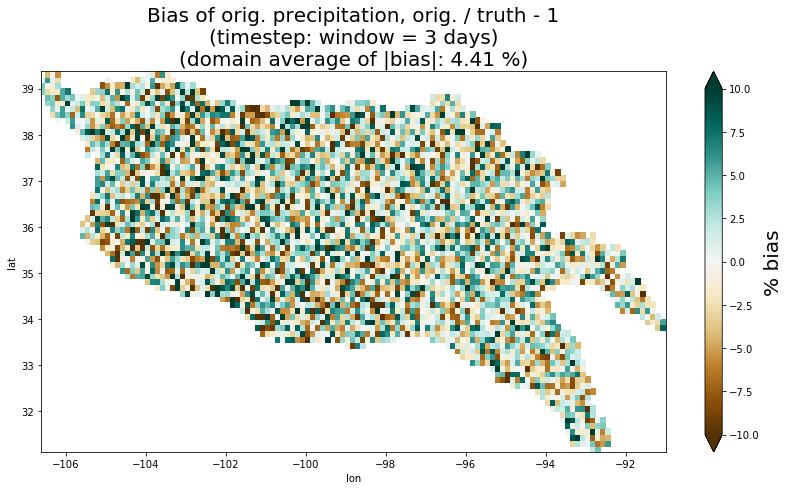

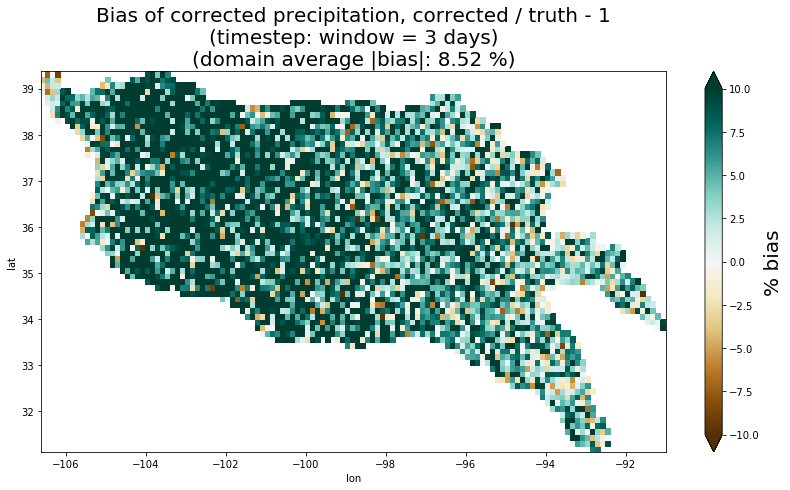

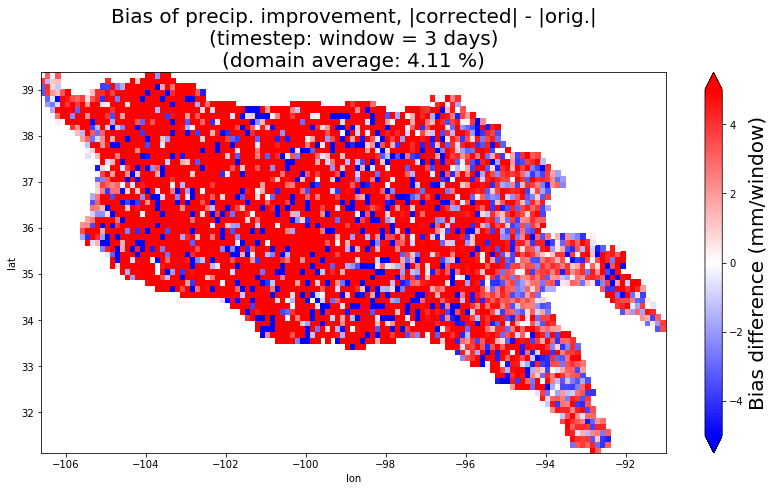

In [170]:
# --- Ensemble-mean bias --- #
# Calculate bias
bias_orig = (prec_orig_window.mean(axis=1) / prec_true_window.mean(axis=1) - 1) * 100
bias_corr = (prec_corr.mean(axis=0) / prec_true_window.mean(axis=1) - 1) * 100
da_bias_orig = da_2D_to_3D_from_SMART(
    dict_array_2D={'bias': bias_orig},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['bias'][0, :, :]
da_bias_corr = da_2D_to_3D_from_SMART(
    dict_array_2D={'bias': bias_corr},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['bias'][0, :, :]
# Bias of original precip.
fig = plt.figure(figsize=(14, 7))
cs = da_bias_orig.plot(add_colorbar=False, cmap='BrBG', vmin=-10, vmax=10)
cbar = plt.colorbar(cs, extend='both').set_label('% bias', fontsize=20)
plt.title('Bias of orig. precipitation, orig. / truth - 1\n'
          '(timestep: window = {} days)\n'
          '(domain average of |bias|: {:.2f} %)'.format(
              window_size,
              float(np.absolute(da_bias_orig).mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'bias_prec_orig.png'),
            format='png', bbox_inches='tight')
# Bias of corrected precip.
fig = plt.figure(figsize=(14, 7))
cs = da_bias_corr.plot(add_colorbar=False, cmap='BrBG', vmin=-10, vmax=10)
cbar = plt.colorbar(cs, extend='both').set_label('% bias', fontsize=20)
plt.title('Bias of corrected precipitation, corrected / truth - 1\n'
          '(timestep: window = {} days)\n'
          '(domain average |bias|: {:.2f} %)'.format(
              window_size,
              float(np.absolute(da_bias_corr).mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'bias_prec_corrected.png'),
            format='png', bbox_inches='tight')
# Improvement of bias (corrected - orig.)
da_bias_diff = np.absolute(da_bias_corr) - np.absolute(da_bias_orig)
fig = plt.figure(figsize=(14, 7))
cs = da_bias_diff.plot(add_colorbar=False, cmap='bwr', vmin=-5, vmax=5)
cbar = plt.colorbar(cs, extend='both').set_label('Bias difference (mm/window)', fontsize=20)
plt.title('Bias of precip. improvement, |corrected| - |orig.|\n'
          '(timestep: window = {} days)\n'
          '(domain average: {:.2f} %)'.format(
              window_size,
              float(da_bias_diff.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'bias_prec_diff.png'),
            format='png', bbox_inches='tight')

In [171]:
# --- Mean correlation --- #
# Calculate correlation
corrcoef_orig = [np.corrcoef(prec_orig_window[i, :], prec_true_window[i, :])[0, 1] for i in range(ncell)]
corrcoef_corr = [np.corrcoef(prec_corr[:, i], prec_true_window[i, :])[0, 1] for i in range(ncell)]
corrcoef_orig = np.asarray(corrcoef_orig)
corrcoef_corr = np.asarray(corrcoef_corr)
da_corrcoef_orig = da_2D_to_3D_from_SMART(
    dict_array_2D={'corrcoef': corrcoef_orig},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['corrcoef'][0, :, :]
da_corrcoef_corr = da_2D_to_3D_from_SMART(
    dict_array_2D={'corrcoef': corrcoef_corr},
    da_mask=da_mask,
    out_time_varname='time',
    out_time_coord=[0])['corrcoef'][0, :, :]

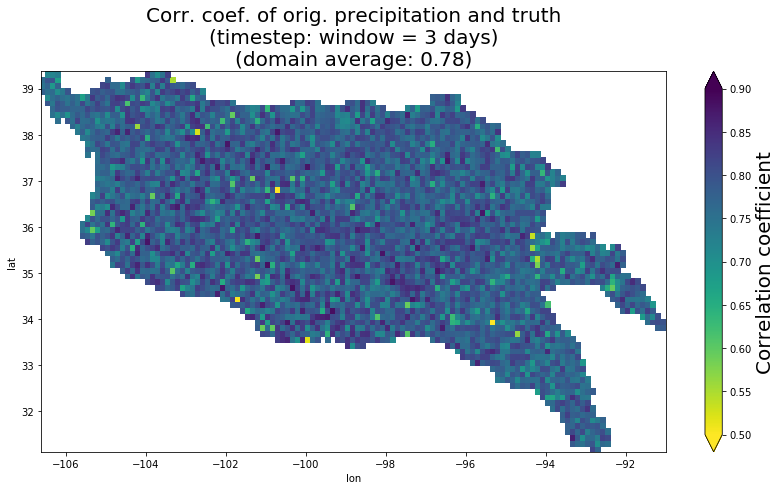

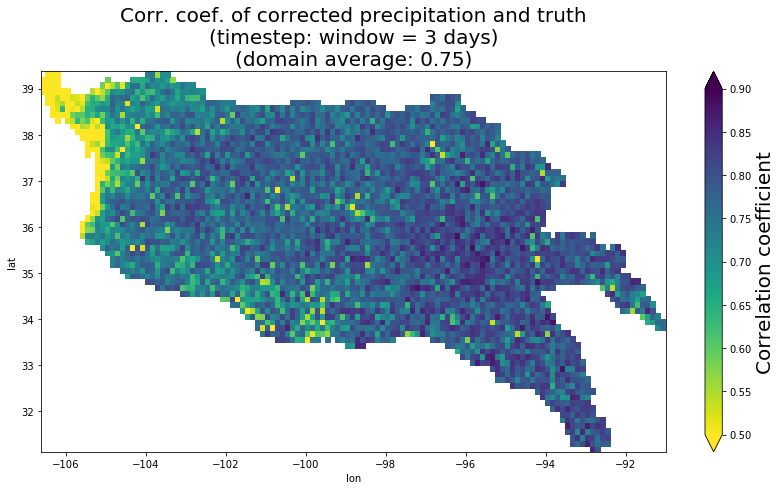

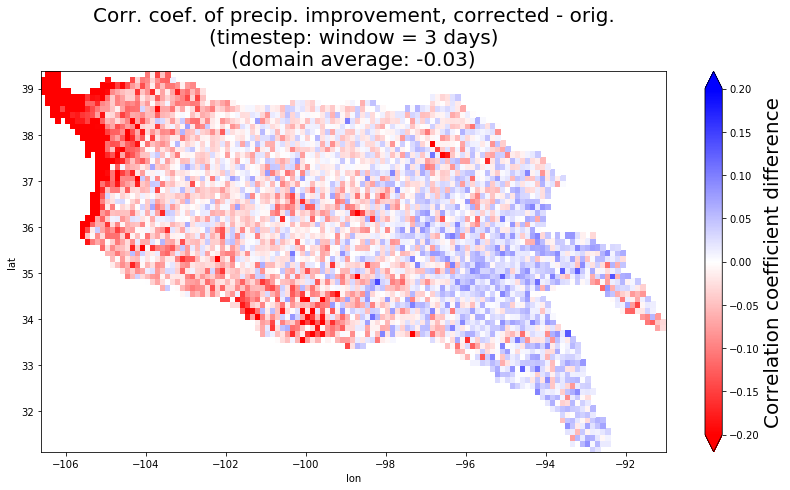

In [172]:
# Corr. coef of original precip.
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig.plot(add_colorbar=False, cmap='viridis_r', vmin=0.5, vmax=0.9)
cbar = plt.colorbar(cs, extend='both').set_label('Correlation coefficient', fontsize=20)
plt.title('Corr. coef. of orig. precipitation and truth\n'
          '(timestep: window = {} days)\n'
          '(domain average: {:.2f})'.format(
              window_size,
              float(da_corrcoef_orig.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef_prec_orig.png'),
            format='png', bbox_inches='tight')
# Corr. coef of corrected precip.
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corr.plot(add_colorbar=False, cmap='viridis_r', vmin=0.5, vmax=0.9)
cbar = plt.colorbar(cs, extend='both').set_label('Correlation coefficient', fontsize=20)
plt.title('Corr. coef. of corrected precipitation and truth\n'
          '(timestep: window = {} days)\n'
          '(domain average: {:.2f})'.format(
              window_size,
              float(da_corrcoef_corr.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef_prec_corrected.png'),
            format='png', bbox_inches='tight')
# Improvement of corr. coef. (corrected - orig.)
da_corrcoef_diff = da_corrcoef_corr - da_corrcoef_orig
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_diff.plot(add_colorbar=False, cmap='bwr_r', vmin=-0.2, vmax=0.2)
cbar = plt.colorbar(cs, extend='both').set_label('Correlation coefficient difference', fontsize=20)
plt.title('Corr. coef. of precip. improvement, corrected - orig.\n'
          '(timestep: window = {} days)\n'
          '(domain average: {:.2f})'.format(
              window_size,
              float(da_corrcoef_diff.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef_prec_diff.png'),
            format='png', bbox_inches='tight')

In [173]:
print(corrcoef_orig.mean(), corrcoef_corr.mean())

0.778974346128 0.753500141389


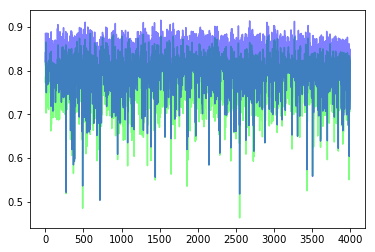

In [22]:
plt.plot(corrcoef_orig, color='lime', alpha=0.5)
plt.plot(corrcoef_corr, color='blue', alpha=0.5)

# Test

In [ ]:
from da_utils import da_2D_to_3D_from_SMART, da_3D_to_2D_for_SMART

In [ ]:
active_cells = np.arange(1, 4000).reshape([1, 3999])
dict_array_2D = {'cell_index': active_cells}  # [1, cell]

In [ ]:
dict_da_3D = da_2D_to_3D_from_SMART(dict_array_2D, da_mask,
                       out_time_varname='time',
                       out_time_coord=[0])

In [ ]:
dict_da_3D['cell_index'].loc[:, 34.6875, -94.9375]

In [100]:
ds_sm = xr.open_dataset(
    ('/civil/hydro/ymao/data_assim/output/synthetic_data/34.6875_-94.9375/'
     'random1.small_SM_error.R_1.Maurer_param/synthetic_meas/synthetic_meas.19800101_19891231.nc'))

In [105]:
da_sm = ds_sm['simulated_surface_sm']
da_sm.time

<xarray.DataArray 'time' (time: 3652)>
array(['1980-01-02T00:00:00.000000000', '1980-01-03T00:00:00.000000000',
       '1980-01-04T00:00:00.000000000', ...,
       '1989-12-29T00:00:00.000000000', '1989-12-30T00:00:00.000000000',
       '1989-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    nlayer   int64 0
  * time     (time) datetime64[ns] 1980-01-02 1980-01-03 1980-01-04 ...

In [106]:
da_daily = da_sm.groupby('time.date').mean(dim='time')